使用训练好的模型输出预测结果

In [ ]:
import torch
from cv_dataset import get_five_fold_datasets

# 训练设备(使用GPU)
def select_device(gpu_id = None):
    if gpu_id is None:
        print("select device CPU")
        return torch.device("cpu")
    if torch.cuda.is_available():
        print("select device GPU")
        return torch.device("cuda:" + str(gpu_id))
    print("have to select device CPU")
    return torch.device("cpu")

def predict_and_display_results(model_path, data_file, device="cpu", top_n=5):
    """
    加载模型并进行预测，展示前top_n个样本的预测结果、ID和坐标
    """
    # 1. 加载模型
    model = torch.load(model_path, map_location=device, weights_only=False)
    model = model.to(device)
    print(model)
    model.eval()
    
    # 2. 加载数据集（复用您的数据生成函数）
    city_trans_dataset, _ = get_five_fold_datasets(data_file)  # fold_indices未使用
    
    # 3. 获取整个数据集的预测结果
    with torch.no_grad():
        features = city_trans_dataset.features.to(device)
        coordinates = city_trans_dataset.coordinates.to(device)
        ids = city_trans_dataset.ids.cpu().numpy()
        outputs = model(features, coordinates)
        
        # 将预测结果移回CPU并转为numpy
        light_pred = outputs['light'].cpu().numpy()
        temp_pred = outputs['temp'].cpu().numpy()
        walk_pred = outputs['walk'].cpu().numpy()
    
    # 4. 展示前top_n个样本
    print(f"\n展示前{top_n}个样本的预测结果：")
    for i in range(min(top_n, len(ids))):
        print(f"样本{i+1}:")
        print(f"  ID: {ids[i]}")
        print(f"  坐标: ({coordinates[i][0].item():.2f}, {coordinates[i][1].item():.2f})")
        print(f"  光污染预测: {light_pred[i][0]:.4f}")
        print(f"  温度预测: [{temp_pred[i][0]:.4f}, {temp_pred[i][1]:.4f}]")
        print(f"  慢行环境预测: {walk_pred[i].tolist()}")
        print("-" * 50)

# 使用示例
if __name__ == "__main__":
    model_path = "./saved_models/model_fold0.pt"
    data_file = "shanghai_data_v3.xlsx"
    device = select_device(2)  
    predict_and_display_results(model_path, data_file, device=device, top_n=5)

select device GPU
MultiTaskGridTransformer(
  (feature_proj): Sequential(
    (0): Linear(in_features=26, out_features=512, bias=True)
    (1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
  )
  (position_encoding): PositionalEncoding(
    (coord_proj): Sequential(
      (0): Linear(in_features=256, out_features=512, bias=True)
      (1): GELU(approximate='none')
      (2): Linear(in_features=512, out_features=512, bias=True)
    )
  )
  (light_encoder): ModuleList(
    (0-1): 2 x AttentionAwareTransformerEncoderLayer(
      (self_attn): MultiheadAttention(
        (out_proj): NonDynamicallyQuantizableLinear(in_features=512, out_features=512, bias=True)
      )
      (linear1): Linear(in_features=512, out_features=2048, bias=True)
      (dropout): Dropout(p=0.1, inplace=False)
      (linear2): Linear(in_features=2048, out_features=512, bias=True)
      (norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
      (norm2): LayerNorm((512,), eps=1e-05, elementwise_affine=

可视化注意力热图

Attention matrix shape (light): torch.Size([2, 1, 7016, 7016])
Attention matrix shape (temp): torch.Size([3, 1, 7016, 7016])
Attention matrix shape (walk): torch.Size([2, 1, 7016, 7016])


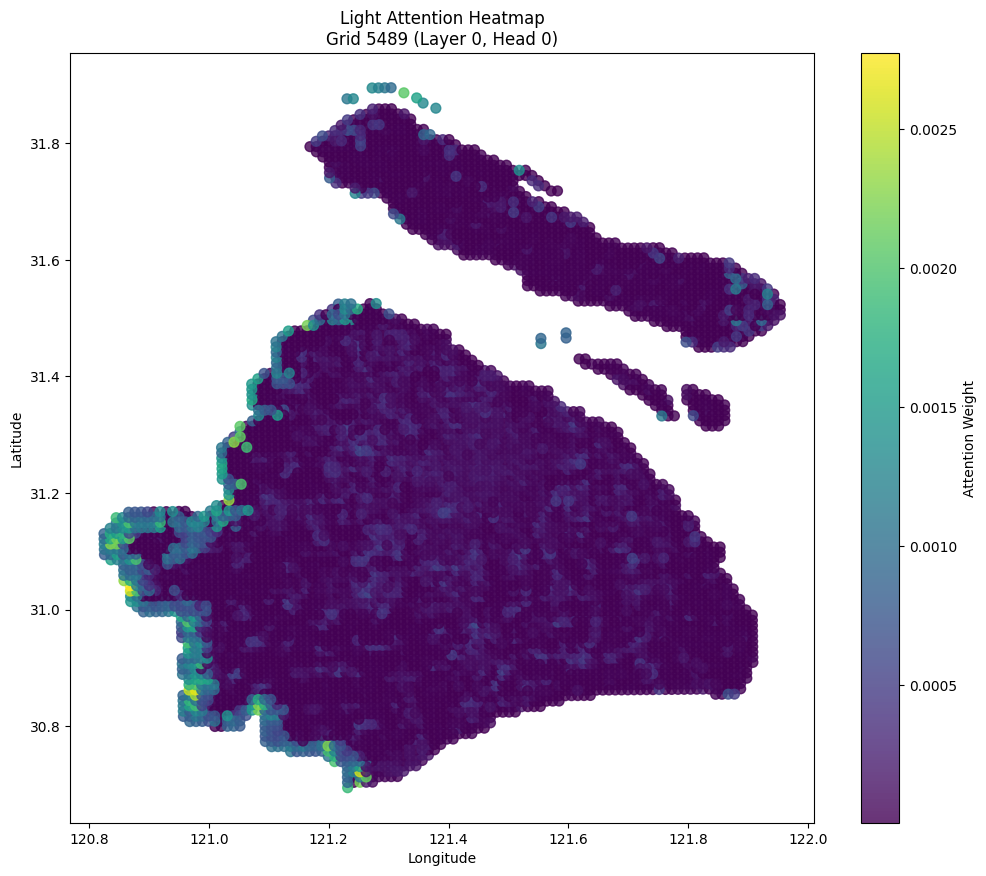

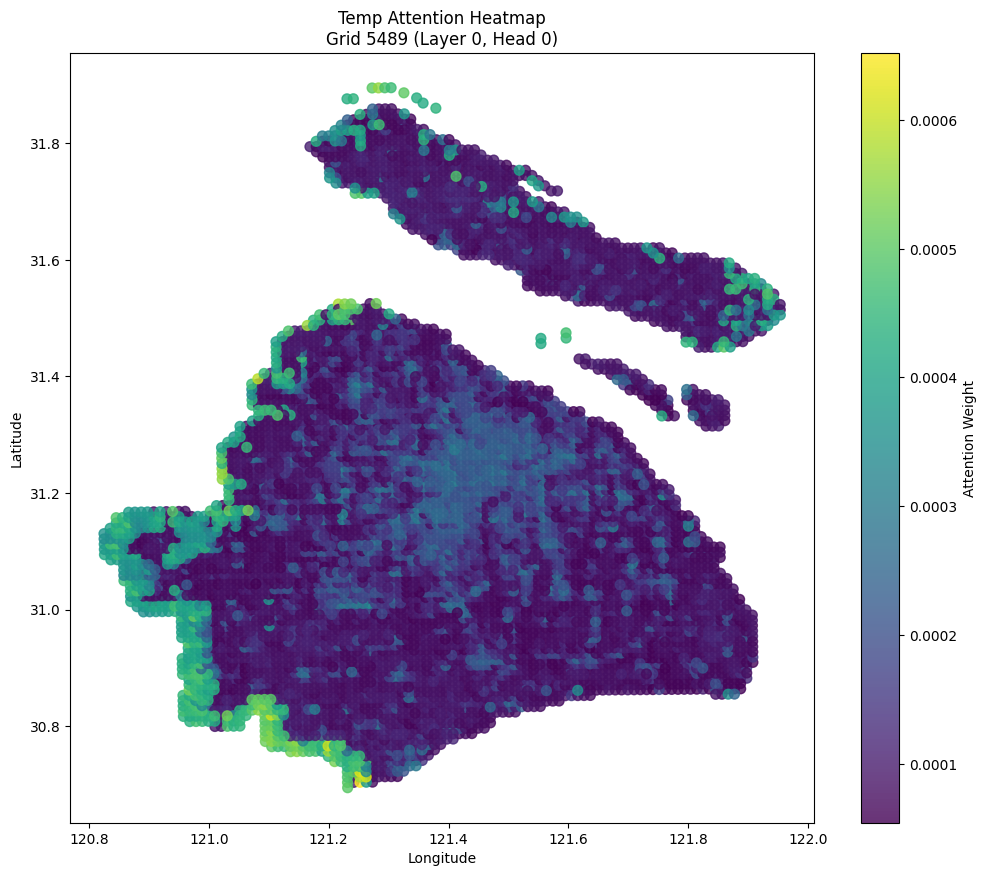

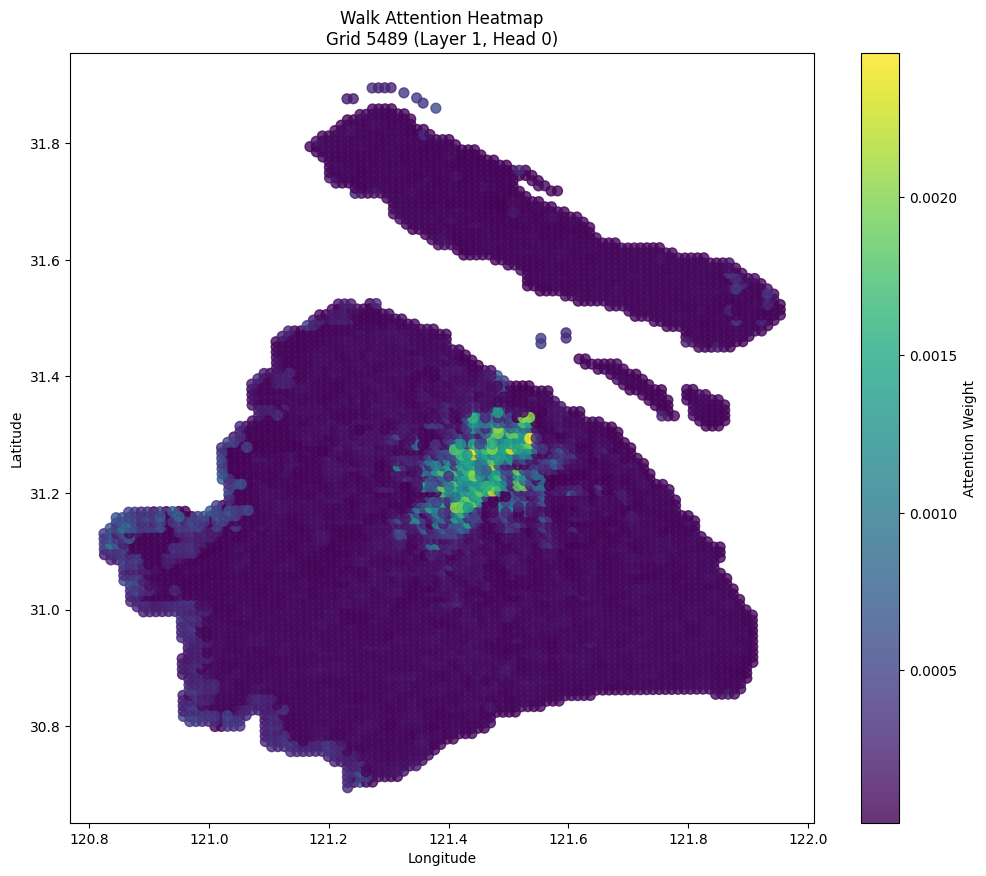

In [6]:
from evel_attention_map import AttentionExplainer

# 分别创建三个任务的可视化实例
light_explainer = AttentionExplainer(fold=0, task='light')
temp_explainer = AttentionExplainer(fold=0, task='temp')
walk_explainer = AttentionExplainer(fold=0, task='walk')

# 绘制不同任务的注意力图
light_explainer.plot_attention_heatmap(layer=0, head=0, grid_id=5489)
temp_explainer.plot_attention_heatmap(layer=0, head=0, grid_id=5489)
walk_explainer.plot_attention_heatmap(layer=1, head=0, grid_id=5489)